--- SYSTEM SETUP ---
Table: 2.4m x 1.8m x 0.25m
Load: 250.0 lbs | Table: 500.0 lbs

--- PHYSICS RESULTS ---
Max Lever Arm: 1.061 m
System Inertia: 189.99 kg-m^2 (Table: 62.4 | Load: 127.6)
Peak Output Torque: 1177.23 Nm
 -> Load Gravity: 1001.2 Nm
 -> Table Unbalance: 111.2 Nm
 -> Inertia Torque: 39.8 Nm
REQUIRED GEARBOX RATING (SF=1.5): 1766 Nm


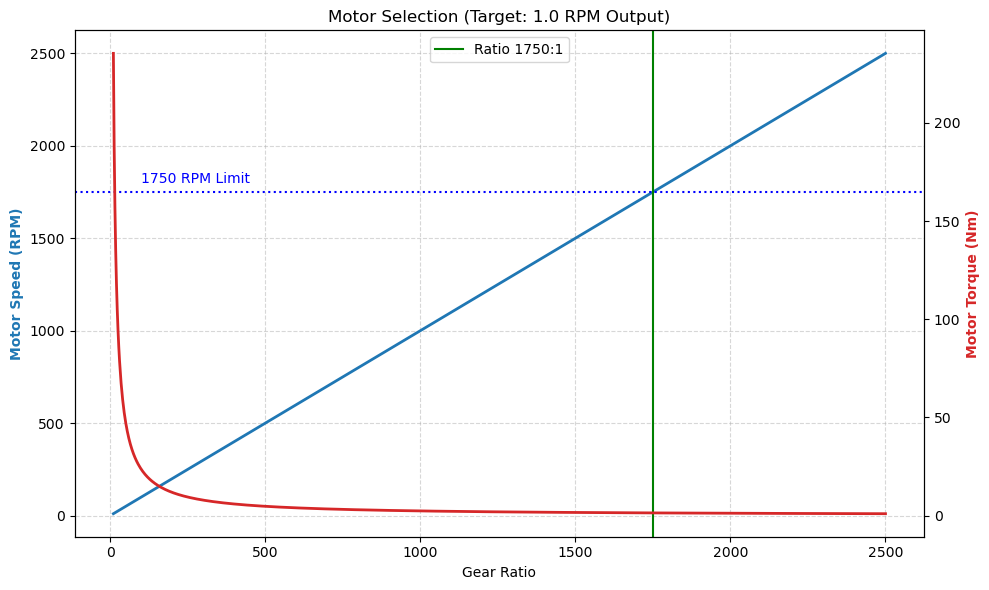


=== FINAL ORDER SPECS ===
Gearbox Ratio:  1750:1
Gearbox Rating: > 1766 Nm
Motor Torque:   1.3454 Nm
Motor Power:    246.56 Watts
Motor Power:    0.3305 HP (Buy 1.0 HP)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. SYSTEM CONFIGURATION ---
# Dimensions
L_axis = 2.4      # Length along rotation axis (m) - No torque, just bending
L_width = 1.8     # Width perpendicular to axis (m) - Creates the lever arm
Thickness = 0.25  # Table thickness (m)
load_y_axis = 0.75
load_x_axis = 0.75

# Weights
m_load_lbs = 250.0
m_table_lbs = 500.0

# Motion Settings
target_rpm = 1.0       # Operating Speed
t_accel = 0.5          # Acceleration Time (s)
SF = 1.5               # Safety Factor
eff_gearbox = 0.75     # Worm Efficiency
# eff_gearbox = 0.4     # Worm Efficiency
unbalance_offset = 0.05 # 5cm CoM offset for table (manufacturing tolerance)

# Conversions & Constants
g = 9.81
m_load_kg = m_load_lbs * 0.453592
m_table_kg = m_table_lbs * 0.453592

print(f"--- SYSTEM SETUP ---")
print(f"Table: {L_axis}m x {L_width}m x {Thickness}m")
print(f"Load: {m_load_lbs} lbs | Table: {m_table_lbs} lbs")

# --- 2. PHYSICS ENGINE ---

# A. Lever Arm Calculation (Worst Case)
# Load is at the edge of the width (L_width/2) and on top surface (Thickness/2)
# Distance from axis r = sqrt(y^2 + z^2)
half_width = L_width / 2.0
half_thick = Thickness / 2.0
r_load_max = np.sqrt(load_y_axis**2 + load_x_axis**2)

# B. Moment of Inertia (I)
# 1. Inertia of Load (Point mass at max radius)
I_load = m_load_kg * r_load_max**2

# 2. Inertia of Table (Rectangular Plate rotating about X-axis)
# Formula: I = (1/12) * M * (Width^2 + Thickness^2)
# Note: Length (2.4m) doesn't affect inertia around X-axis
I_table = (1/12) * m_table_kg * (L_width**2 + Thickness**2)

I_total = I_load + I_table

# C. Torque Components
# 1. Gravity (Load at 90 deg horizontal)
T_gravity_load = m_load_kg * g * half_width

# 2. Gravity (Table Unbalance)
T_gravity_table = m_table_kg * g * unbalance_offset

# 3. Acceleration Torque (T = I * alpha)
omega_rads = target_rpm * 2 * np.pi / 60
alpha = omega_rads / t_accel
T_inertia = I_total * alpha

# 4. Friction (Estimate)
T_friction = 25.0 

# D. Total Requirement
T_peak_output = T_gravity_load + T_gravity_table + T_inertia + T_friction
T_rated_req = T_peak_output * SF

print(f"\n--- PHYSICS RESULTS ---")
print(f"Max Lever Arm: {r_load_max:.3f} m")
print(f"System Inertia: {I_total:.2f} kg-m^2 (Table: {I_table:.1f} | Load: {I_load:.1f})")
print(f"Peak Output Torque: {T_peak_output:.2f} Nm")
print(f" -> Load Gravity: {T_gravity_load:.1f} Nm")
print(f" -> Table Unbalance: {T_gravity_table:.1f} Nm")
print(f" -> Inertia Torque: {T_inertia:.1f} Nm")
print(f"REQUIRED GEARBOX RATING (SF={SF}): {T_rated_req:.0f} Nm")

# --- 3. SELECTION CURVES ---

ratios = np.linspace(10, 2500, 1000)
req_speed = target_rpm * ratios
req_torque = T_rated_req / (ratios * eff_gearbox)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_title(f"Motor Selection (Target: {target_rpm} RPM Output)")
ax1.set_xlabel("Gear Ratio")
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Speed Curve
color = 'tab:blue'
ax1.set_ylabel('Motor Speed (RPM)', color=color, fontweight='bold')
ax1.plot(ratios, req_speed, color=color, linewidth=2)
ax1.axhline(1750, color='blue', linestyle=':')
ax1.text(100, 1800, "1750 RPM Limit", color='blue')

# Torque Curve
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Motor Torque (Nm)', color=color, fontweight='bold')
ax2.plot(ratios, req_torque, color=color, linewidth=2)

# Find Solution
target_ratio = 1750.0 / target_rpm
ax1.axvline(target_ratio, color='green', label=f'Ratio {target_ratio:.0f}:1')
ax1.legend(loc='upper center')

plt.tight_layout()
plt.show()

# --- 4. FINAL RECOMMENDATION ---
motor_torque_Nm = T_rated_req / (target_ratio * eff_gearbox)
motor_speed_rads = (1750 * 2 * np.pi / 60)

# Power Calculations
power_watts = motor_torque_Nm * motor_speed_rads
power_hp = power_watts / 746.0

print(f"\n=== FINAL ORDER SPECS ===")
print(f"Gearbox Ratio:  {target_ratio:.0f}:1")
print(f"Gearbox Rating: > {T_rated_req:.0f} Nm")
print(f"Motor Torque:   {motor_torque_Nm:.4f} Nm")
print(f"Motor Power:    {power_watts:.2f} Watts")
print(f"Motor Power:    {power_hp:.4f} HP (Buy {np.ceil(power_hp)} HP)")

In [8]:
def check_gear_ratio(N_target):
    # 1. Calculate Motor Speed required to get 1 RPM output
    mot_speed_rpm = target_rpm * N_target
    
    # 2. Calculate Motor Torque required
    # Note: Using T_peak_output (Physical Load) for motor sizing, usually without SF for running load
    # If you want to match your conservative "SF=4" sizing, use T_rated_req
    mot_torque_nm = T_rated_req / (N_target * eff_gearbox)
    
    # 3. Calculate Power
    mot_power_hp = (mot_torque_nm * mot_speed_rpm * 2 * np.pi / 60) / 746.0
    
    print(f"--- CHECKING RATIO {N_target}:1 ---")
    print(f"Motor Speed:  {mot_speed_rpm:.1f} RPM")
    print(f"Motor Torque: {mot_torque_nm:.2f} Nm")
    print(f"Motor Power:  {mot_power_hp:.4f} HP")
    
    if mot_speed_rpm > 1800:
        print("⚠️ WARNING: Speed exceeds standard 1750 RPM motor base speed.")

# EXAMPLE USAGE:
check_gear_ratio(100)
check_gear_ratio(500)
check_gear_ratio(1750)

--- CHECKING RATIO 100:1 ---
Motor Speed:  100.0 RPM
Motor Torque: 23.54 Nm
Motor Power:  0.3305 HP
--- CHECKING RATIO 500:1 ---
Motor Speed:  500.0 RPM
Motor Torque: 4.71 Nm
Motor Power:  0.3305 HP
--- CHECKING RATIO 1750:1 ---
Motor Speed:  1750.0 RPM
Motor Torque: 1.35 Nm
Motor Power:  0.3305 HP
